# Lung mask-based nearest label post processing for LUNA16 dataset

In [29]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from statannotations.Annotator import Annotator
import sys
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/lobe_seg')
from luna16_preprocess import get_kfolds
# from dataloader import test_dataloader
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/thoraxtools/func/vis')
from vis import vis
import nibabel as nib
from skimage.transform import resize

In [30]:
def vis_overlay_slices(img, label, xyz, orientation="LAS", label_orientation="LAS", cmap="turbo", clip_range=(-1024, 600), mask_range=(0,5)):
    label = np.where(label == 0, np.nan, label)
    img_clip_sag, img_clip_cor, img_clip_ax = vis.clip_LAS(img, xyz) if orientation == "LAS" else vis.clip_LPS(img, xyz)
    label_clip_sag, label_clip_cor, label_clip_ax = vis.clip_LAS(label, xyz) if label_orientation == "LAS" else vis.clip_LPS(label,
                                                                                                               xyz)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    f, ax = plt.subplots(1, 3, figsize=(15, 15))

    sag = ax[0].imshow(img_clip_sag, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0],
                       vmax=clip_range[1])
    ax[0].imshow(label_clip_sag, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    ax[1].imshow(img_clip_cor, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0], vmax=clip_range[1])
    ax[1].imshow(label_clip_cor, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    ax[2].imshow(img_clip_ax, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0], vmax=clip_range[1])
    ax[2].imshow(label_clip_ax, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])


In [43]:
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/')
from dataloader import test_dataloader
from models import unet512
import yaml
import random
import torch
from monai.utils import set_determinism
from monai.metrics import DiceMetric

import os
import sys
from tqdm import tqdm
import torch
import SimpleITK as sitk
import gc
import psutil
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import (
    Compose,
    AsDiscrete,
    AddChannel,
    EnsureType,
    EnsureTyped,
    AsDiscreted,
    LoadImaged,
    Orientationd,
    AddChanneld,
    Spacingd,
    ScaleIntensityRanged,
    EnsureTyped,
    CropForegroundd,
    Invertd,
    Compose,
    Spacing,
    Resize,
    Orientation,
)
from monai.data import DataLoader, Dataset
from pandas import DataFrame
import numpy as np
from postprocess import get_largest_cc, nearest_label_filling
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/thoraxtools/func")
import vis.paral_clip_overlay_mask as overlay


def load_config(config_name, config_dir):
    with open(os.path.join(config_dir, config_name)) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config

CONFIG_DIR = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs"
config_id = "test"
config = load_config(f"Config_{config_id}.YAML", CONFIG_DIR)
set_determinism(seed=config["random_seed"])
random.seed(config["random_seed"])
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device("cuda:0")
model = unet512(6).to(device)
model_path = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold1/0511cval_best_model.pth"
test_metric = DiceMetric(include_background=False, reduction="none")

def test_dataloader(config, val_images):
    # test_transforms = Compose([
    #     LoadImaged(keys=["image", "label"]),
    #     AddChanneld(keys=["image", "label"]),
    #     Spacingd(keys=["image", "label"], pixdim=config["pix_dim"], mode=("bilinear", "nearest")),
    #     Orientationd(keys=["image", "label"], axcodes="RAS"),
    #     ScaleIntensityRanged(keys=["image"], a_min=config["window"][0], a_max=config["window"][1], b_min=0.0, b_max=1.0,
    #                          clip=True),
    #     # CropForegroundd(keys=["image", "label"], source_key="image"),
    #     EnsureTyped(keys=["image", "label"]),
    # ])
    # test_transforms = Compose([
    #     LoadImaged(keys=["image", "label"]),
    #     AddChanneld(keys=["image", "label"]),
    #     Spacingd(keys=["image", "label"], pixdim=config["pix_dim"], mode=("bilinear")),
    #     Orientationd(keys=["image", "label"], axcodes="RAS"),
    #     ScaleIntensityRanged(keys=["image", "label"], a_min=config["window"][0], a_max=config["window"][1], b_min=0.0, b_max=1.0,
    #                          clip=True),
    #     EnsureTyped(keys=["image", "label"]),
    # ])
    test_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image"], pixdim=config["pix_dim"], mode=("bilinear")),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=config["window"][0], a_max=config["window"][1], b_min=0.0, b_max=1.0,
                             clip=True),
        EnsureTyped(keys=["image"]),
    ])
    invert_transforms = None
    LABEL_DIR = config["label_dir"]

    if config["dataset"] == "vlsp":
        val_file_names = [f"lvlsetseg_{os.path.basename(name)}" for name in val_images]
    elif config["dataset"] == "luna16":
        val_file_names = [f"{os.path.basename(name)[:-4]}_LobeSegmentation.nrrd" for name in val_images]
    elif config["dataset"] == "mixed":
        val_file_names = []
        for i in val_images:
            name, suffix = os.path.splitext(os.path.basename(i))
            if suffix == ".mhd":
                val_file_names.append(f"{name}_LobeSegmentation.nrrd")
            elif suffix == ".gz":
                fname = f"{name[:-4]}_LobeSegmentation.nii.gz" if name[1] == '.' else f"{name[:-4]}_lvlsetseg.nii.gz"
                val_file_names.append(fname)
    else:
        print("Error: define dataset in Config.YAML")
        return
    val_labels = [os.path.join(LABEL_DIR, name) for name in val_file_names]
    val_files = [
        {"image": image_name, "label": label_name, "image_path": image_name}
        for image_name, label_name in zip(val_images, val_labels)
    ]
    test_ds = Dataset(data=val_files, transform=test_transforms)
    test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, shuffle=False)
    return test_loader, invert_transforms

def run_inference(image, pixdim, output_shape, axcodes, config, config_id, device, model, model_path, test_metric):
    test_loader, _ = test_dataloader(config, image)
    device = torch.device(config["device"])
    model.load_state_dict(torch.load(model_path))
    model.eval()
    test_metric.reset()
    post_pred_transforms = Compose([
        EnsureTyped(keys=["label", "pred"]),
        AsDiscreted(keys="pred", argmax=True, to_onehot=6),
        AsDiscreted(keys="label", to_onehot=6),
        Orientationd(keys=["pred"], axcodes=axcodes),
        Spacingd(keys=["pred"], pixdim=pixdim, mode="nearest"), 
        Resized(keys=["pred"], spatial_size=output_shape, mode="nearest"),
    ])
    measure_transforms = Compose([EnsureType(), AddChannel(), AsDiscrete(to_onehot=6)])
    image_paths = []
    with torch.no_grad():
        for test_data in test_loader:
            test_inputs, image_path = (
                test_data["image"].to(device),
                # test_data["label"][0, 0, :, :, :].detach().cpu().numpy(),
                test_data["image_path"][0],
            )
            image_paths.append(image_path)
            test_data["pred"] = sliding_window_inference(test_inputs, config["crop_shape"], 4, model)
            test_data["pred"] = test_data["pred"].detach().cpu()
            test_data = [post_pred_transforms(i) for i in decollate_batch(test_data)]
            test_data = test_data[0]
            print(test_data["pred"].shape, test_data["label"].shape)
            
            # fuse with lung mask using nearest label filling
            pred = torch.argmax(test_data["pred"], dim=0)
            pred = lungmask_filling(get_largest_cc(pred), image_path)
            test_data["pred"] = measure_transforms(pred)
            
            test_metric(y_pred=[test_data["pred"]], y=[test_data["label"]])
            metric = test_metric.aggregate()
            print(metric)
            
            label_map = torch.argmax(test_data["pred"], dim=0)

            # transform to image space orientation
            # print(f"before transform {postprocess.shape}")
            # postprocess = vis_transforms(postprocess)[0]
            # las_pred = las_transforms(pred)[0]
            # lps_pred = lps_transforms(pred)[0]
            # print(f"after transform {postprocess.shape}")
            
    return label_map

### Notes on orientation for LUNA16
* nib reads LUNA16 files as LPS
* sitk reads LUNA16 files as SPL
* output of our unet is RAS
* orientation

### Orientation for VLSP
* nib reads VLSP as LAS

In [44]:
images = ["1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444", "00000667time20170526"]
# images = ["00001033time20181022"]
raw_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/"
raw_paths = [os.path.join(raw_dir, f"{i}.nii.gz") for i in images]

In [45]:
from lungmask import mask

raws, lungmasks, unets, preds, vis_preds = [],[],[],[],[]

for i in range(len(images)):
    # get johof and lsm
    raw_nii = nib.load(raw_paths[i])
    raw_img = raw_nii.get_fdata()
    # raw_sitk = sitk.ReadImage(raw_paths[i])
    # lungmask_img = mask.apply(raw_sitk)
    s = raw_img.shape
    pixdim = raw_nii.header.get_zooms()
    axcodes = nib.orientations.aff2axcodes(raw_nii.affine)
    axcodes = ''.join(axcodes)
    print(axcodes)
    
    # get model inference
    pred_img = run_inference([raw_paths[i]], pixdim, raw_nii.shape, axcodes, config, config_id, device, model, model_path, test_metric)
    
    raws.append(raw_img)
    # lungmasks.append(lungmask_img)
    # unets.append(unet_img)
    preds.append(pred_img)
    # vis_preds.append(vis_pred_img)

LPS
(6, 512, 512, 200) (6, 512, 512, 200)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1244.88it/s]


(512, 512, 200) (512, 512, 200)
tensor([[0.9644, 0.9283, 0.9092, 0.8630, 0.9392]])
LAS
(6, 512, 512, 393) (6, 512, 512, 393)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 756.38it/s]


(512, 512, 393) (512, 512, 393)
tensor([[0.9862, 0.9862, 0.9822, 0.9657, 0.9837]])


In [47]:
# lungmasks = [np.swapaxes(img, 0,2) for img in lungmasks]
print(pred_img.shape)
raw_nii.shape

(512, 512, 393)


(512, 512, 393)

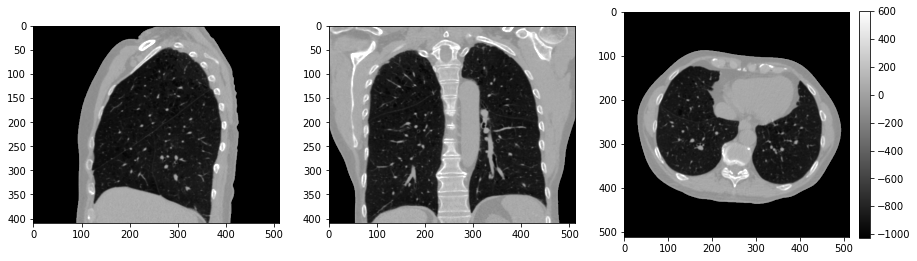

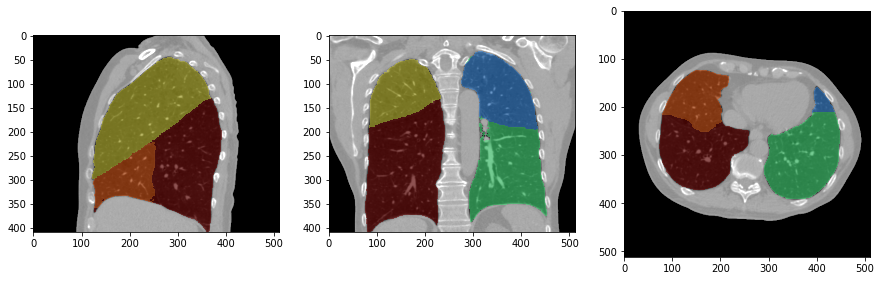

In [42]:
fig_dir = '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/tmp/figures'
xyzs = [(150,200,100)]
# xyzs = [(75, (120,175,212)), (50, (200, 305, 170))]

for i, xyz in enumerate(xyzs):
    vis.vis_slices(raws[0], xyz, orientation="LAS")
    # vis.vis_slices(preds[0], (100,100,100), orientation="Identity", clip_range=(0,5), cmap="turbo")
    # vis_overlay_slices(raws[i], lungmasks[i], xyz, orientation="LPS", label_orientation="LPS", cmap="turbo")
    vis_overlay_slices(raws[i], preds[i], xyz, orientation="LAS", label_orientation="LAS", cmap="turbo")
    # vis_overlay_slices(raws[i], vis_preds[i], xyz, orientation="LAS", label_orientation="LAS", cmap="turbo")

In [38]:
raw_nii = nib.load(raw_paths[0])
print(raws[0].shape, vis_preds[0].shape)
o = nib.orientations.aff2axcodes(raw_nii.affine)
print(o)
''.join(o)

(512, 512, 393) (512, 512, 393)
('L', 'P', 'S')


'LPS'

In [11]:
import numpy as np
from skimage import measure
from scipy import ndimage
import argparse
import SimpleITK as sitk
from tqdm import tqdm
import glob
from lungmask import mask
def get_lungmaks(raw_path):
    """
    segment lungmask using R231 from https://github.com/JoHof/lungmask
    """
    raw_sitk = sitk.ReadImage(raw_path)
    lungmask = mask.apply(raw_sitk)
    lungmask = np.swapaxes(lungmask, 0,2)
    
    return lungmask
def lungmask_filling(cc, raw_path):
    lungmask = get_lungmaks(raw_path)
    print(cc.shape, lungmask.shape)
    dst_no_labels = np.zeros((5, *cc.shape))
    no_label = np.where(lungmask, 1, 0) - np.where(cc, 1, 0)
    for i in range(5):
        label = i+1
        binary = np.where(cc==label, 1, 0)
        inv_binary = np.where(cc==label, 0, 1)
        dst = -ndimage.distance_transform_cdt(binary) + ndimage.distance_transform_cdt(inv_binary)
        dst_no_labels[i, :,:,:] = np.where(no_label, dst, 0)

    nearest = np.argmin(dst_no_labels, axis=0)
    nearest = np.where(no_label, nearest + 1, 0)
    filled = cc + nearest
    return get_largest_cc(filled)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 373.91it/s]


(512, 512, 200) (512, 512, 200)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

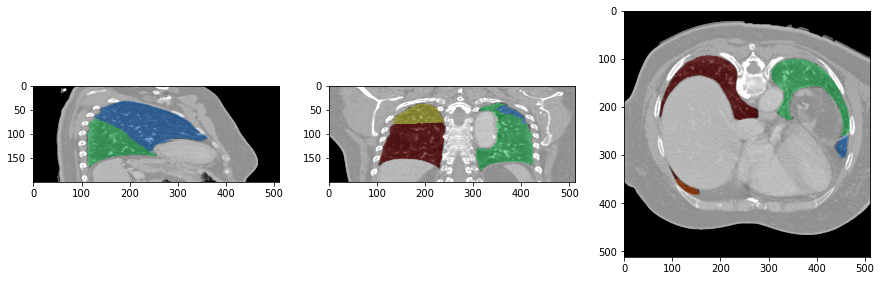

In [23]:
xyz = (400,380,50)
vis.vis_overlay_slices(raws[0], vis_preds[0], xyz, cmap="turbo")
postprocess = lungmask_filling(get_largest_cc(vis_preds[0]), raw_paths[0])
vis.vis_overlay_slices(raws[0], postprocess[0], xyz, cmap="turbo")

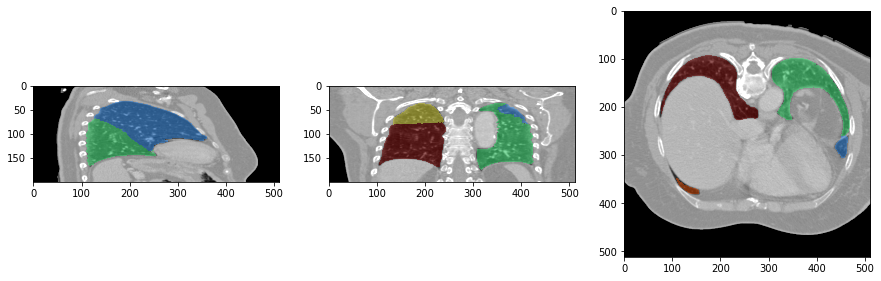

In [26]:
vis.vis_overlay_slices(raws[0], postprocess, xyz, cmap="turbo")